## Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from time import time
import pprint
import joblib
from functools import partial
import csv

from ContestHelper import *

import gc
import os
cur_path = os.getcwd()

import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import Booster

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

In [2]:
TRAIN_0_4_PATH = cur_path + "/prepared_data/train_0_4.pkl"
TRAIN_5_12_PATH = cur_path + "/prepared_data/train_5_12.pkl"
TRAIN_13_22_PATH = cur_path + "/prepared_data/train_13_22.pkl"
TRAIN_LABELS_PATH = "train_labels.csv"

In [3]:
train_raw_0_4 = pd.read_pickle(TRAIN_0_4_PATH)
train_raw_5_12 = pd.read_pickle(TRAIN_5_12_PATH)
train_raw_13_22 = pd.read_pickle(TRAIN_13_22_PATH)

In [4]:
targets = pd.read_csv(TRAIN_LABELS_PATH)
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))

## Feature engineering

In [5]:
NUM_COLS = ['level', 
            'page',
            'hover_duration',
            'room_coor_x', 'screen_coor_x',
            'room_coor_y', 'screen_coor_y',
            'delta_absolute_coor_x', 'delta_absolute_coor_y',
            'absolute_coor_x', 'absolute_coor_y',
            'radius_absolute_coor',
            'tangent_absolute_coor',
            'delta_radius_absolute_coor', 'delta_tangent_absolute_coor',
            'elapsed_time_diff']

CAT_COLS = ['full_event_name',
            "text",
            "event_name"]

FULL_EVENT_NAME = {
    "0_4": train_raw_0_4["full_event_name"].unique().tolist(),  
    "5_12": train_raw_5_12["full_event_name"].unique().tolist(),  
    "13_22": train_raw_13_22["full_event_name"].unique().tolist()  
}

SUB_LEVELS = {'0_4': [1, 2, 3, 4],
              '5_12': [5, 6, 7, 8, 9, 10, 11, 12],
              '13_22': [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]}

In [6]:
def agg_by_elapsed_time_diff(col_name, iter_col, feature_suffix):
    agg = [
        *[pl.col(col_name).filter(pl.col(col_name) == c).count().alias(f"{c}_{col_name}_{feature_suffix}")
          for c in iter_col],
        *[pl.col("elapsed_time_diff").filter(pl.col(col_name) == c).std().alias(f"{c}_{col_name}_ET_std_{feature_suffix}") 
          for c in iter_col],
        *[pl.col("elapsed_time_diff").filter(pl.col(col_name) == c).mean().alias(f"{c}_{col_name}_ET_mean_{feature_suffix}") 
          for c in iter_col],
        *[pl.col("elapsed_time_diff").filter(pl.col(col_name) == c).sum().alias(f"{c}_{col_name}_ET_sum_{feature_suffix}") 
          for c in iter_col],
        *[pl.col("elapsed_time_diff").filter(pl.col(col_name) == c).median().alias(f"{c}_{col_name}_ET_median_{feature_suffix}") 
          for c in iter_col],
        *[pl.col("elapsed_time_diff").filter(pl.col(col_name) == c).max().alias(f"{c}_{col_name}_ET_max_{feature_suffix}") 
          for c in iter_col]
    ]
    return agg

def feature_engineer_pl(x, group, feature_suffix):  
     
    full_event_names = FULL_EVENT_NAME[group]
    levels = SUB_LEVELS[group]

    x = pl.from_pandas(x)
    aggs = [
        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") 
          for c in CAT_COLS],

        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") 
          for c in NUM_COLS],
        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") 
          for c in NUM_COLS],
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") 
          for c in NUM_COLS],
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") 
          for c in NUM_COLS],
        *[pl.col(c).median().alias(f"{c}_median_{feature_suffix}") 
          for c in NUM_COLS],
        *[pl.col(c).quantile(0.25).alias(f"{c}_q25_{feature_suffix}") 
          for c in NUM_COLS],
        *[pl.col(c).quantile(0.75).alias(f"{c}_q75_{feature_suffix}") 
          for c in NUM_COLS]]
    
    aggs.extend(agg_by_elapsed_time_diff("full_event_name", full_event_names, feature_suffix))
    aggs.extend(agg_by_elapsed_time_diff("level", levels, feature_suffix))

    df = x.groupby(['session_id'], maintain_order=True).agg(aggs).sort("session_id")
    return df.to_pandas()

In [7]:
def pipeline(df:pd.DataFrame, grp) -> pd.DataFrame:
    df = createDeltaElapsedTimeFeatures(df)
    df = feature_engineer_pl(df, grp, grp)
    df = createTimeFeatures(df)
    df = df.set_index('session_id')
    return df

In [8]:
df1 = pipeline(train_raw_0_4, "0_4")
df2 = pipeline(train_raw_5_12, "5_12")
df3 = pipeline(train_raw_13_22, "13_22")

In [9]:
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 23562 users info


In [10]:
with open("FEATURES_Q.csv", "r") as f:
    FEATURES_Q = [f.readline().split() for i in range(1,19)]

## Tunning params

In [11]:
# # Reporting util for different optimizers
# def report_perf(optimizer, X, y, title="model", callbacks=None):
#     """
#     A wrapper for measuring time and performance of optmizers
    
#     optimizer = a sklearn or a skopt optimizer
#     X = the training set 
#     y = our target
#     title = a string label for the experiment
#     """
#     start = time()
    
#     if callbacks is not None:
#         optimizer.fit(X, y, callback=callbacks)
#     else:
#         optimizer.fit(X, y)
        
#     d=pd.DataFrame(optimizer.cv_results_)
#     best_score = optimizer.best_score_
#     best_score_std = d.iloc[optimizer.best_index_].std_test_score
#     best_params = optimizer.best_params_
    
#     print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
#            + u"\u00B1"+" %.3f") % (time() - start, 
#                                    len(optimizer.cv_results_['params']),
#                                    best_score,
#                                    best_score_std))    
#     print('Best parameters:')
#     pprint.pprint(best_params)
#     print()
#     return best_params

In [12]:
# # Setting the scoring function
# scoring = make_scorer(f1_score, average="macro")

In [13]:
# kf = KFold(n_splits=5, shuffle=True, random_state=0)

In [14]:
# # Setting the basic regressor
# reg = lgb.LGBMClassifier(boosting_type= 'gbdt',
#                         objective= 'binary',
#                         metric= 'binary_logloss',
#                         n_jobs=1, 
#                         verbose=-1,
#                         random_state=42)

In [15]:
# # Setting the search space
# search_spaces = {
#     'learning_rate': Real(0.01, 0.06, 'log-uniform'),    # Boosting learning rate
#     'n_estimators': Integer(300, 600),                   # Number of boosted trees to fit
#     'num_leaves': Integer(4, 256),                       # Maximum tree leaves for base learners
#     'max_depth': Integer(4, 32),                         # Maximum tree depth for base learners, <=0 means no limit
#     'subsample': Real(0.01, 1.0, 'log-uniform'),             # Subsample ratio of the training instance
#     'colsample_bytree': Real(0.01, 1.0, 'log-uniform'),      # Subsample ratio of columns when constructing each tree
#     'alpha': Real(8.0, 32.0, 'log-uniform'),            # L1 regularization
#    }

In [16]:
# # ITERATE THRU QUESTIONS 1 THRU 18
# for t in range(1,19):
#     print(f"MODEL -- {t}")
#     # USE THIS TRAIN DATA WITH THESE QUESTIONS
#     FEATURES = FEATURES_Q[t-1]
#     if t<=3: 
#         grp = '0-4'
#         train_x = df1
#     elif t<=13: 
#         grp = '5-12'
#         train_x = df2
#     elif t<=22: 
#         grp = '13-22'
#         train_x = df3
        
#     # TRAIN DATA
#     train_users = train_x.index.values
#     train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
    
#     # Wrapping everything up into the Bayesian optimizer
#     opt = BayesSearchCV(estimator=reg,                                    
#                         search_spaces=search_spaces,                      
#                         scoring=scoring,                                  
#                         cv=kf,                                           
#                         n_iter=60,                                        # max number of trials
#                         n_points=3,                                       # number of hyperparameter sets evaluated at the same time
#                         n_jobs=-1,                                        # number of jobs
#                         iid=False,                                        # if not iid it optimizes on the cv score
#                         return_train_score=False,                         
#                         refit=False,                                      
#                         optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
#                         random_state=24)                                   # random state for replicability    
    
#     # Running the optimizer
#     overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
#     time_limit_control = DeadlineStopper(total_time=60 * 60 * 6) # We impose a time limit (6 hours)

#     X = train_x[FEATURES].astype('float32')
#     y = train_y['correct']
#     best_params = report_perf(opt,X ,y ,'LightGBM_regression', 
#                             callbacks=[overdone_control, time_limit_control])
    

#     with open('hyperparams_tunning.csv','a', newline="") as f:
#         w = csv.writer(f)
#         w.writerow(dict(best_params).keys())
#         w.writerow(dict(best_params).values())
    
# print()

## Check with tunned params

In [25]:
params = {'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbose':-1,
       'random_state':42}

dtypes = {'colsample_bytree': np.float16,
        'learning_rate': np.float16,
        'max_depth': np.int16,
        'n_estimators': np.int16,
        'num_leaves': np.int16,
        'alpha': np.float16,
        'subsample': np.float16}
feat_df = pd.read_csv("hyperparams_tunning.csv", dtype=dtypes)
lgb_params = [{**{j:feat_df.loc[i, j] for j in feat_df.columns}, **params} for i in range(18)]

In [29]:
kf = KFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(kf.split(df1)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        FEATURES = FEATURES_Q[t-1]
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: 
            grp = '0-4'
            # TRAIN DATA
            train_x = df1.iloc[train_index]
            train_users = train_x.index.values
            train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
            
            # VALID DATA
            valid_x = df1.iloc[test_index]
            valid_users = valid_x.index.values
            valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        elif t<=13: 
            grp = '5-12'
            # TRAIN DATA
            train_x = df2.iloc[train_index]
            train_users = train_x.index.values
            train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
            
            # VALID DATA
            valid_x = df2.iloc[test_index]
            valid_users = valid_x.index.values
            valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        elif t<=22: 
            grp = '13-22'
            # TRAIN DATA
            train_x = df3.iloc[train_index]
            train_users = train_x.index.values
            train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
            
            # VALID DATA
            valid_x = df3.iloc[test_index]
            valid_users = valid_x.index.values
            valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
    
        # TRAIN MODEL        
        clf = LGBMClassifier(**lgb_params[t-1])
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=0)

        # SAVE MODEL, PREDICT VALID OOF
        models[f'{i}_{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################

#########################
### Fold 2
#########################

#########################
### Fold 3
#########################

#########################
### Fold 4
#########################

#########################
### Fold 5
#########################



0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

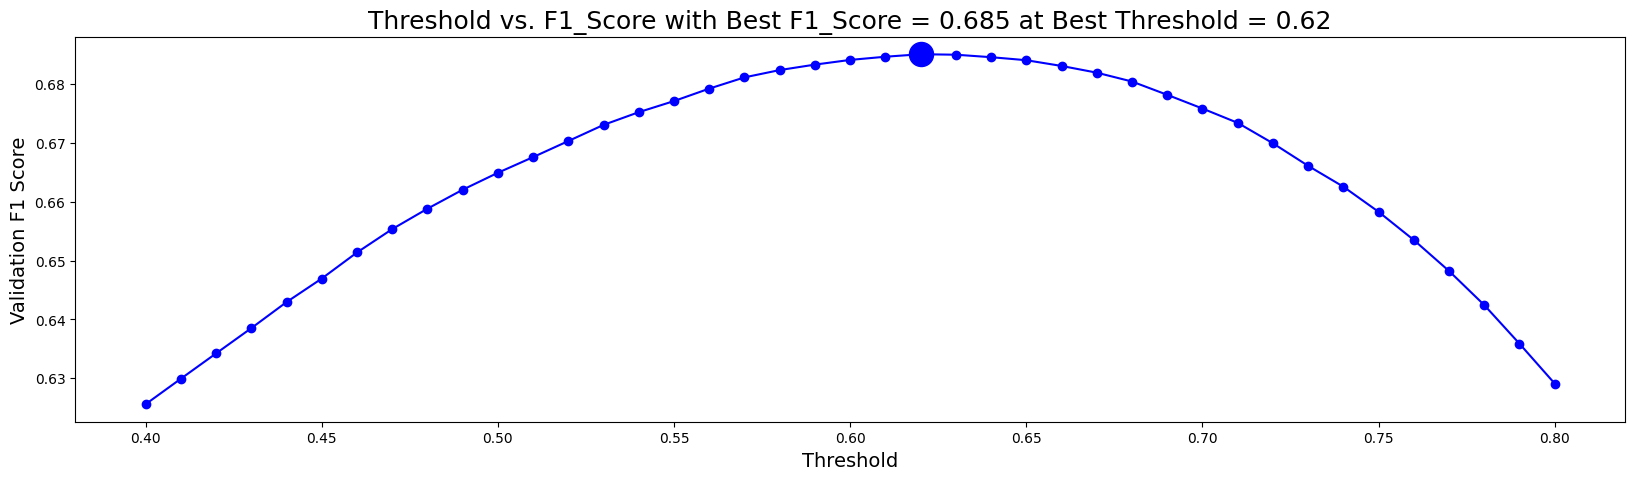

In [30]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [31]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.6643546428518514
Q1: F1 = 0.5135819892725368
Q2: F1 = 0.5143371055232685
Q3: F1 = 0.6525388196282245
Q4: F1 = 0.633278737938473
Q5: F1 = 0.6309000646917934
Q6: F1 = 0.6105601457029493
Q7: F1 = 0.5570015356525547
Q8: F1 = 0.6145819974989355
Q9: F1 = 0.5717077307724923
Q10: F1 = 0.5915977237398554
Q11: F1 = 0.5162726119387308
Q12: F1 = 0.5046594145117111
Q13: F1 = 0.6180160374097627
Q14: F1 = 0.5660400293851837
Q15: F1 = 0.5045947066917474
Q16: F1 = 0.5419486917977159
Q17: F1 = 0.5046072937370522
==> Overall F1 = 0.6851039338034662
